# **our step by step approach to the problem statement**


*   Firstly studying about spectrograms and their properties that is the pictoral representation of sound
*   then trying out few models to classify the spectrograms initially on a small set of data with limited classes to find out the best model architecture then using that for the larger datasets
*   trying few shot classification for identifying the birds and animal species through their voice data
*   moving on to the the human voices, we start with voice activity detection wherein first we classify the given audio segment into classes based on whether it contains human speech or not
*   after classification the speech part goes through character diarization where we apply clustering algorithms on the MFCC features vectors to differentiate speakers
*   combining all these into a pipeline to aid in providing labels before real time speeh to text conversion







# **1) Spectrograms**

In [ ]:
!pip install soundata

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.0/162.0 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.7/413.7 kB 35.9 MB/s eta 0:00:00
  Created wheel for jams: filename=jams-0.3.4-py3-none-any.whl size=64901 sha256=4157807f8af436888d9b98e396f4f91d58065956e6ecb

In [ ]:
import soundata

dataset = soundata.initialize('urbansound8k')
dataset.download()
dataset.validate()

5.61GB [01:29, 66.9MB/s]                           
1.15MB [00:00, 4.35MB/s]                            
100%|██████████| 8732/8732 [00:44<00:00, 196.69it/s]


({'metadata': {}, 'clips': {}}, {'metadata': {}, 'clips': {}})

In [ ]:
clip_ids = dataset.clip_ids
print(clip_ids[:5])

['135776-2-0-49', '46654-6-0-0', '57320-0-0-24', '134717-0-0-26', '174276-7-5-0']


In [ ]:

for clip_id in dataset.clip_ids:
    clip = dataset.clip(clip_id)

    waveform, sr = clip.audio
    print(f"Clip ID: {clip.clip_id}")
    print(f"Audio shape: {waveform.shape}")
    print(f"Sample rate: {sr}")
    print(f"Clip metadata: {clip}")
    break


Clip ID: 135776-2-0-49
Audio shape: (176400,)
Sample rate: 44100
Clip metadata: Clip(
  audio_path="/root/sound_datasets/urbansound8k/audio/fold1/135776-2-0-49.wav",
  clip_id="135776-2-0-49",
  audio: The clip's audio
            * np.ndarray - audio signal
            * float - sample rate,
  class_id: The clip's class id.
            * int - integer representation of the class label (0-9). See Dataset Info in the documentation for mapping,
  class_label: The clip's class label.
            * str - string class name: air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music,
  fold: The clip's fold.
            * int - fold number (1-10) to which this clip is allocated. Use these folds for cross validation,
  freesound_end_time: The clip's end time in Freesound.
            * float - end time in seconds of the clip in the original freesound recording,
  freesound_id: The clip's Freesound ID.
            * str - ID of the

**initial audio wave signal. We apply the short time fourier transform to convert it into spectrgrams**


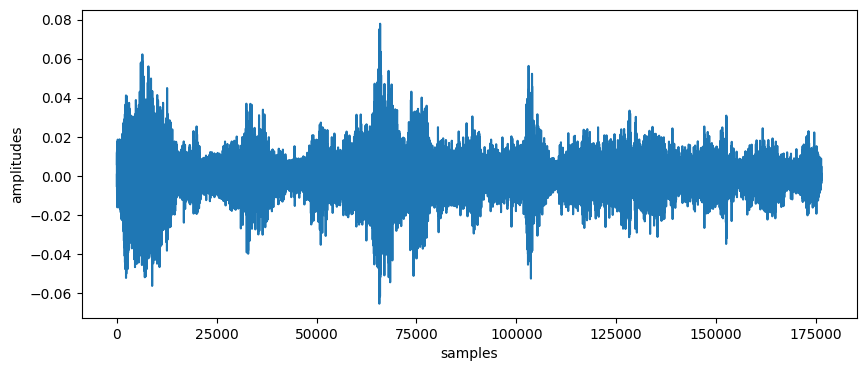

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(waveform)
plt.xlabel("samples")
plt.ylabel("amplitudes")
plt.show()

**Sample log mel spectrogram. We use the mel scale beacuse it simulates human hearing tendency to percieve lower frequency better than the higher ones**

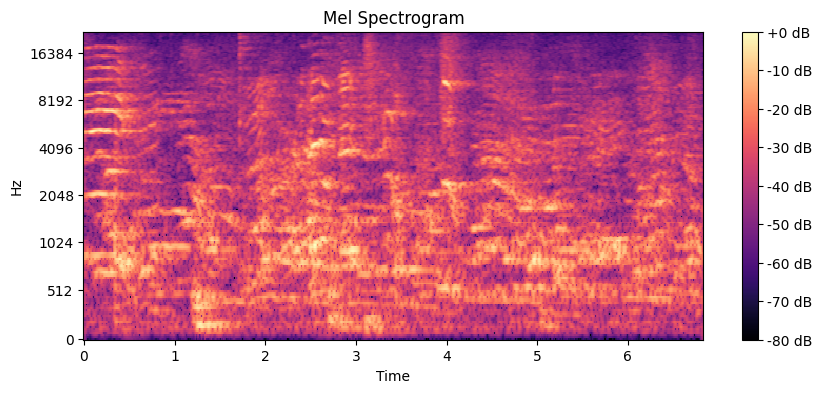

In [ ]:
import librosa
import librosa.display
import numpy as np

mel_spectrogram = librosa.feature.melspectrogram(y=waveform, sr=sr, n_mels=200, fmax=8000, hop_length=300)

mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram")
plt.show()

In [ ]:
mel_spectrogram.shape

(128, 345)

# **2) Preprocessing all the audio files in urbansound 8k dataset into spectrograms and storing on drive**

In [ ]:
import numpy as np
import pandas as pd
import os
import librosa

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
data = []
path = '/content/drive/MyDrive/spectrograms/'

for clip_id in dataset.clip_ids:
    clip = dataset.clip(clip_id)

    waveform, sr = clip.audio
    mel_spectrogram = librosa.feature.melspectrogram(y=waveform, sr=sr, n_mels=200, fmax=8000, hop_length=300)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    save_path = path + f"{clip_id}.npy"
    np.save(save_path,mel_spectrogram)
    class_label = clip.class_label
    data.append((save_path,class_label))





In [ ]:
pd.DataFrame(data, columns=["file_path", "label"]).to_csv(os.path.join(path, "processed_data.csv"), index=False)


# **3)Training on the stored spectrograms using normal CNNs**

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import cv2
import os

spectrogram_dir = "/content/mel_spectrograms"
X = []
y = []

for fold in sorted(os.listdir(spectrogram_dir)):
    fold_path = os.path.join(spectrogram_dir, fold)

    for file in sorted(os.listdir(fold_path)):
        img_path = os.path.join(fold_path, file)
        img = cv2.resize(img, (128, 128))

        X.append(img)
        y.append(fold)

X = np.array(X) / 255.0
y = np.array(y)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Dataset Shape:", X.shape, y.shape)

Dataset Shape: (1000, 128, 128) (1000,)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,393,034 (28.20 MB)

 Trainable params: 7,393,034 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))


Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 837ms/step - accuracy: 0.7377 - loss: 0.8312 - val_accuracy: 0.8650 - val_loss: 0.3744
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 809ms/step - accuracy: 0.8753 - loss: 0.3484 - val_accuracy: 0.8650 - val_loss: 0.3681
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 885ms/step - accuracy: 0.8817 - loss: 0.3420 - val_accuracy: 0.8650 - val_loss: 0.3322
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 878ms/step - accuracy: 0.9014 - loss: 0.2571 - val_accuracy: 0.9050 - val_loss: 0.3523
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 830ms/step - accuracy: 0.9233 - loss: 0.2363 - val_accuracy: 0.9100 - val_loss: 0.3127


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.9110 - loss: 0.3266
Test Accuracy: 0.9100
Test Loss: 0.3127


# **Training the stored spectrograms on the resNET50 model**

In [ ]:
CSV_FILE = '/content/drive/MyDrive/spectrograms/processed_data.csv'
label_df = pd.read_csv(CSV_FILE)
label_dict = dict(zip(label_df["file_path"], label_df["label"]))

print(f"Loaded {len(label_dict)} labels from CSV.")

Loaded 8732 labels from CSV.


In [ ]:
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

In [ ]:
class SpectrogramDataset(Dataset):
    def __init__(self, data_dir,label_dict,label_map,target_shape = (200, 589),transform=None):
        self.data_dir = data_dir
        self.files = [f for f in os.listdir(data_dir) if f.endswith('.npy')]
        self.label_dict = label_dict
        self.transform = transform
        self.target_shape = target_shape
        self.label_map = label_map
        self.valid_files = self._filter_valid_files()


    def _filter_valid_files(self):
        valid_files = []
        for file_name in self.files:
            file_path = os.path.join(self.data_dir, file_name)
            spectrogram = np.load(file_path)

            if spectrogram.shape == self.target_shape:
                valid_files.append(file_name)

        print(f"Filtered {len(self.files) - len(valid_files)} invalid files. Using {len(valid_files)} valid files.")
        return valid_files

    def __len__(self):
        return len(self.valid_files)

    def __getitem__(self, idx):
        file_name = self.valid_files[idx]
        file_path = os.path.join(self.data_dir, file_name)
        spectrogram = np.load(file_path)

        spectrogram = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min())
        spectrogram = np.stack([spectrogram] * 3, axis=0)

        spectrogram = torch.tensor(spectrogram, dtype=torch.float32)
        label_str = self.label_dict.get(file_path, -1)
        label = torch.tensor(self.label_map.get(label_str, -1), dtype=torch.long)

        return spectrogram, label

In [ ]:
class SpectrogramResNet(nn.Module):
    def __init__(self, num_classes):
        super(SpectrogramResNet, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  # Adjusting first conv layer
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)  # Adjusting final layer

    def forward(self, x):
        return self.model(x)

In [ ]:
num_classes = 10

model = SpectrogramResNet(num_classes).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SpectrogramResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [ ]:
DATA_DIR='/content/drive/MyDrive/spectrograms'
batch_size = 32
dataset = SpectrogramDataset(DATA_DIR,label_dict,label_map,(200, 589))


Filtered 1407 invalid files. Using 7325 valid files.


In [ ]:
train_size = 6900
test_size = 425
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")

Train size: 6900, Test size: 425


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
num_epochs = 2

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for spectrograms, labels in train_loader:
        spectrograms, labels = spectrograms.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(spectrograms)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")


Epoch [1/2], Loss: 0.0691
Epoch [2/2], Loss: 0.0387


In [ ]:
model.eval()

SpectrogramResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [ ]:
from sklearn.metrics import accuracy_score

# Initialize variables
all_labels = []
all_preds = []
running_loss = 0.0

# Disable gradient calculation for evaluation
with torch.no_grad():
    for spectrograms, labels in test_loader:
        spectrograms, labels = spectrograms.to(device), labels.to(device)

        # Forward pass
        outputs = model(spectrograms)
        _, preds = torch.max(outputs, 1)  # Get the predicted class by taking the max

        # Calculate loss (if necessary)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Store predictions and labels for further analysis
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Calculate final accuracy
accuracy = accuracy_score(all_labels, all_preds)
avg_loss = running_loss / len(test_loader)

print(f"Test Loss: {avg_loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Loss: 0.3715
Test Accuracy: 89.88%


# **Training the stored spectrograms on VGGnet model**

In [ ]:
import torch.nn as nn
import torchvision.models as models

class VGG_AudioCNN(nn.Module):
    def __init__(self, num_classes):
        super(VGG_AudioCNN, self).__init__()
        self.vgg = models.vgg16(pretrained=True)
        self.vgg.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        return self.vgg(x)

num_classes = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG_AudioCNN(num_classes).to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 157MB/s]


In [ ]:
print(model)

VGG_AudioCNN(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16

In [ ]:
DATA_DIR='/content/drive/MyDrive/spectrograms'
batch_size = 32
dataset = SpectrogramDataset(DATA_DIR,label_dict,label_map,(200, 589))


In [ ]:
train_size = 6900
test_size = 425
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")

TypeError: object of type 'Dataset' has no len()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    cnt=0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        cnt+=1
        if cnt/1000==0:
          print(cnt)
    train_acc = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}, Train Acc: {train_acc:.2f}%")

print("done")

In [ ]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    return 100 * correct / total

val_acc = evaluate(model, val_loader)
test_acc = evaluate(model, test_loader)

print(f"Validation Accuracy: {val_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")


# **Voice activity detection using resNET**

**we are using the speech activity detection dataset from kaggle**

In [ ]:
!kaggle datasets download -d lazyrac00n/speech-activity-detection-datasets


Dataset URL: https://www.kaggle.com/datasets/lazyrac00n/speech-activity-detection-datasets
License(s): CC-BY-NC-SA-4.0
speech-activity-detection-datasets.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile

dataset_path = "speech-activity-detection-datasets.zip"
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/speech_non_speech")

print("Dataset extracted successfully!")

Dataset extracted successfully!


**This dataset contains 3 main classes i)male audio ii)female audio  and  iii)noise**

**For current less time and simplicity we didnt explicitly distinguish the male audio from female audio rather we put both of them into a single class label called human audio whereas noise had the label no human audio**

**The main purpose was to filter out the speech segments in a long audio file in order to make the character diarization easier which would have otherwise taken the noises into consideration as well**

In [ ]:
import os
import librosa
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
import soundfile as sf


In [ ]:
DATASET_PATH = '/content/drive/MyDrive/speech_non_speech/Data/Audio'
SPEECH_DIR = "/content/drive/MyDrive/processed_speech_spectros"
NON_SPEECH_DIR = "/content/drive/MyDrive/non_speech_spectros"


In [ ]:
SAMPLE_RATE = 16000
CHUNK_DURATION = 1
N_MELS = 128
HOP_LENGTH = 512

# Function to process audio into 1-sec chunks
def split_and_pad_audio(file_path, label):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    chunk_length = sr * CHUNK_DURATION
    num_chunks = int(np.ceil(len(y) / chunk_length))

    for i in range(num_chunks):
        start_sample = i * chunk_length
        end_sample = start_sample + chunk_length
        chunk = y[start_sample:end_sample]

        if len(chunk) < chunk_length:
            chunk = np.pad(chunk, (0, chunk_length - len(chunk)))

        mel_spec = librosa.feature.melspectrogram(y=chunk, sr=sr, n_mels=N_MELS, hop_length=HOP_LENGTH)
        log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

        save_dir = SPEECH_DIR if label == "speech" else NON_SPEECH_DIR
        np.save(os.path.join(save_dir, f"{os.path.basename(file_path).replace('.wav', '')}_chunk{i}.npy"), log_mel_spec)


speech_folders = ["Female/PTDB-TUG", "Female/TMIT", "Male/PTDB-TUG", "Male/TMIT"]
noise_folders = ["Noizeus/Babble", "Noizeus/Car", "Noizeus/NoNoise", "Noizeus/Restaurant", "Noizeus/Station", "Noizeus/Street", "Noizeus/Train"]

speech_files = []
for folder in speech_folders:
    folder_path = os.path.join(DATASET_PATH, folder)
    speech_files.extend([os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".wav")])

noise_files = []
for folder in noise_folders:
    folder_path = os.path.join(DATASET_PATH, folder)
    noise_files.extend([os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".wav")])

for file in speech_files:
    split_and_pad_audio(file, "speech")

for file in noise_files:
    split_and_pad_audio(file, "non_speech")

print("Processing complete! Spectrograms saved.")


Processing complete! Spectrograms saved.


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import numpy as np
from torchvision import models, transforms

# Dataset Class
class SpectrogramDataset(data.Dataset):
    def __init__(self, data_dir, label, transform=None):
        self.data_dir = data_dir
        self.label = label
        self.transform = transform
        self.files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".npy")]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        spectrogram = np.load(self.files[idx])
        spectrogram = torch.tensor(spectrogram, dtype=torch.float32).unsqueeze(0)  # (1, H, W)

        # Convert to 3-channel for ResNet
        spectrogram = spectrogram.repeat(3, 1, 1)  # (3, H, W)

        if self.transform:
            spectrogram = self.transform(spectrogram)

        return spectrogram, self.label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [ ]:
speech_dataset = SpectrogramDataset(SPEECH_DIR, label=1, transform=transform)
non_speech_dataset = SpectrogramDataset(NON_SPEECH_DIR, label=0, transform=transform)

# Merge & Load Data
dataset = data.ConcatDataset([speech_dataset, non_speech_dataset])
dataloader = data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)


In [ ]:
class SpectrogramResNet(nn.Module):
    def __init__(self, num_classes=2):
        super(SpectrogramResNet, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  # Adjust for spectrogram
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)  # Adjust output layer

    def forward(self, x):
        return self.model(x)

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpectrogramResNet(num_classes=2).to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 167MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 5
log_interval = 100

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    batch_start_time = time.time()

    for batch_idx, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # Logging every 100 images
        if (batch_idx + 1) * inputs.size(0) % log_interval == 0:
            batch_time = time.time() - batch_start_time
            print(f"Epoch {epoch+1}/{num_epochs}, Image {total}/{len(dataset)}, "
                  f"Batch Loss: {loss.item():.4f}, Accuracy: {correct/total:.4f}, "
                  f"Time per batch: {batch_time:.2f}s")
            batch_start_time = time.time()

    print(f"Epoch {epoch+1}/{num_epochs} Completed! "
          f"Total Loss: {running_loss/len(dataloader):.4f}, Final Accuracy: {correct/total:.4f}")

print("Training complete!")

Epoch 1/5, Image 800/3498, Batch Loss: 0.1378, Accuracy: 0.9950, Time per batch: 60.32s
Epoch 1/5, Image 1600/3498, Batch Loss: 0.0189, Accuracy: 0.9962, Time per batch: 66.74s
Epoch 1/5, Image 2400/3498, Batch Loss: 0.0002, Accuracy: 0.9954, Time per batch: 79.26s
Epoch 1/5, Image 3200/3498, Batch Loss: 0.0030, Accuracy: 0.9941, Time per batch: 74.20s
Epoch 1/5, Image 3498/3498, Batch Loss: 0.0193, Accuracy: 0.9934, Time per batch: 25.81s
Epoch 1/5 Completed! Total Loss: 0.0248, Final Accuracy: 0.9934
Epoch 2/5, Image 800/3498, Batch Loss: 0.0662, Accuracy: 0.9962, Time per batch: 11.71s
Epoch 2/5, Image 1600/3498, Batch Loss: 0.0047, Accuracy: 0.9956, Time per batch: 11.77s
Epoch 2/5, Image 2400/3498, Batch Loss: 0.0010, Accuracy: 0.9967, Time per batch: 11.79s
Epoch 2/5, Image 3200/3498, Batch Loss: 0.0012, Accuracy: 0.9966, Time per batch: 11.83s
Epoch 2/5, Image 3498/3498, Batch Loss: 0.4130, Accuracy: 0.9963, Time per batch: 4.45s
Epoch 2/5 Completed! Total Loss: 0.0149, Final Ac

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/speech_detection_resnet18.pth")

In [ ]:
import torch
import torchaudio
import torchaudio.transforms as T
import soundfile as sf

class SpectrogramResNet(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(SpectrogramResNet, self).__init__()
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
        self.model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.fc = torch.nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpectrogramResNet(num_classes=2)
model.load_state_dict(torch.load("/content/drive/MyDrive/speech_detection_resnet18.pth", map_location=device))
model.to(device)
model.eval()

# Audio Processing Functions
def split_audio(audio_path, chunk_size=1):
    """Splits an audio file into 1-second chunks"""
    waveform, sr = torchaudio.load(audio_path)

    # Convert stereo to mono by averaging channels
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    num_samples = sr * chunk_size
    chunks = []

    for i in range(0, waveform.shape[1], num_samples):
        chunk = waveform[:, i:i + num_samples]
        if chunk.shape[1] < num_samples:  # Pad last chunk
            pad = torch.zeros((waveform.shape[0], num_samples - chunk.shape[1]))  # Match channels
            chunk = torch.cat((chunk, pad), dim=1)
        chunks.append(chunk)

    return chunks, sr

def convert_to_spectrogram(chunk, sr):
    """Converts a waveform chunk to a log-mel spectrogram"""
    mel_spec = T.MelSpectrogram(sample_rate=sr, n_fft=1024, hop_length=256, n_mels=64)(chunk)
    mel_spec = T.AmplitudeToDB()(mel_spec)

    # Ensure exactly 3 channels for ResNet
    if mel_spec.shape[0] == 1:
        mel_spec = mel_spec.repeat(3, 1, 1)  # Convert 1-channel to 3-channel
    elif mel_spec.shape[0] == 2:
        mel_spec = mel_spec[:1, :, :].repeat(3, 1, 1)  # Select first channel & repeat to 3

    return mel_spec.unsqueeze(0)  # Add batch dimension

# Speech Detection & Reconstruction
def process_audio(input_audio_path, output_audio_path):
    """Processes the audio file, removes non-speech portions, and saves the result"""
    chunks, sr = split_audio(input_audio_path)
    speech_segments = []

    for i, chunk in enumerate(chunks):
        spectrogram = convert_to_spectrogram(chunk, sr).to(device)

        with torch.no_grad():
            prediction = model(spectrogram)
            predicted_label = torch.argmax(prediction, dim=1).item()

        if predicted_label == 1:  # Speech detected
            speech_segments.append(chunk)

    # Combining speech segments and save
    if speech_segments:
        speech_waveform = torch.cat(speech_segments, dim=1).cpu()
        sf.write(output_audio_path, speech_waveform.numpy().T, sr)
        print(f"Processed file saved as: {output_audio_path}")
    else:
        print("No speech detected in the file.")



Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
<ipython-input-17-f7207e237256>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental

In [ ]:
input_audio_path = "/content/Goku-Knocks-Gohan-Down-To-The-Ground-Dragon-Ball-Z-_shorts-_TubeRipper.com_.wav"
output_audio_path = "/content/filtered_speech.wav"
process_audio(input_audio_path, output_audio_path)


Processed file saved as: /content/filtered_speech.wav


# **using MFCC vectorization for speaker diarization**

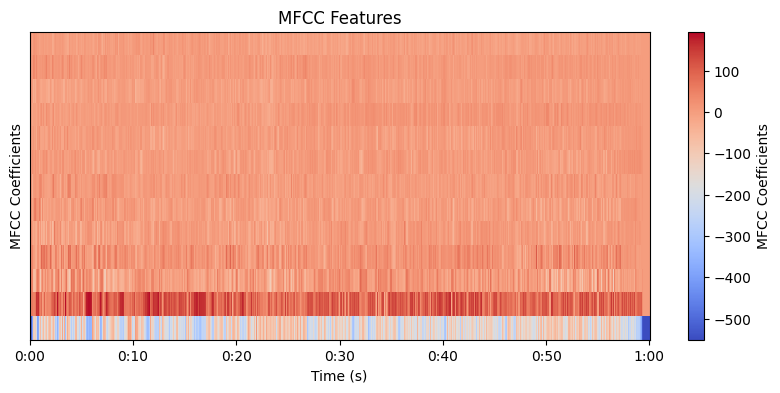

MFCCs Shape: (13, 1876)


In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

audio_path = "/content/filtered_speech.wav"
y, sr = librosa.load(audio_path, sr=16000)

mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # Getting 13 MFCC coefficients

# Ploting the MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis="time", sr=sr)
plt.colorbar(label="MFCC Coefficients")
plt.title("MFCC Features")
plt.xlabel("Time (s)")
plt.ylabel("MFCC Coefficients")
plt.show()

print("MFCCs Shape:", mfccs.shape)


In [ ]:
import librosa

def segment_audio(audio_path, sr=16000, segment_length=1.0):
    """Splits the speech-only audio into 1-second segments."""
    y, sr = librosa.load(audio_path, sr=sr)
    segment_samples = int(segment_length * sr)

    segments = [y[i : i + segment_samples] for i in range(0, len(y), segment_samples)]
    timestamps = [(i / sr, (i + segment_samples) / sr) for i in range(0, len(y), segment_samples)]

    return segments, timestamps, sr


speech_audio_path = "/content/filtered_speech.wav"
speech_segments, timestamps, sr = segment_audio(speech_audio_path)

print(f"Total Speech Segments: {len(speech_segments)}")


Total Speech Segments: 60


In [ ]:
import numpy as np

def extract_mfcc_from_segments(segments, sr, n_mfcc=13):
    mfcc_features = []
    for seg in segments:
        mfccs = librosa.feature.mfcc(y=seg, sr=sr, n_mfcc=n_mfcc)
        mfcc_mean = np.mean(mfccs, axis=1)
        mfcc_features.append(mfcc_mean)
    return np.array(mfcc_features)

# Extract MFCC features
mfcc_features_list = extract_mfcc_from_segments(speech_segments, sr)

print("MFCC Feature Shape:", mfcc_features_list.shape)

MFCC Feature Shape: (60, 13)


**Using the DBSCAN for clustering instead of k means clustering because the number of speakers that can be present are variable**

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Standardize the MFCC features
X_scaled = StandardScaler().fit_transform(mfcc_features_list)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=2.4, min_samples=2, metric='euclidean')
labels = dbscan.fit_predict(X_scaled)

print("Speaker Labels:", labels)


Speaker Labels: [-1 -1  0 -1 -1 -1 -1 -1 -1  1 -1 -1  2  2  2 -1 -1  0 -1 -1  1 -1 -1 -1
  2  2 -1  2 -1  2  2  2 -1  2  2 -1  2  2  2  2  2  2  2  2  2 -1 -1 -1
 -1 -1  2  2 -1  2  2  2  2  2  2 -1]


In [ ]:
# Create a list of speaker diarization results
diarization_results = [{"start_time": ts[0], "end_time": ts[1], "speaker": f"Speaker_{label}"}
                       for ts, label in zip(timestamps, labels)]

# Print results
for entry in diarization_results:
    print(entry)


{'start_time': 0.0, 'end_time': 1.0, 'speaker': 'Speaker_-1'}
{'start_time': 1.0, 'end_time': 2.0, 'speaker': 'Speaker_-1'}
{'start_time': 2.0, 'end_time': 3.0, 'speaker': 'Speaker_-1'}
{'start_time': 3.0, 'end_time': 4.0, 'speaker': 'Speaker_-1'}
{'start_time': 4.0, 'end_time': 5.0, 'speaker': 'Speaker_-1'}
{'start_time': 5.0, 'end_time': 6.0, 'speaker': 'Speaker_-1'}
{'start_time': 6.0, 'end_time': 7.0, 'speaker': 'Speaker_-1'}
{'start_time': 7.0, 'end_time': 8.0, 'speaker': 'Speaker_-1'}
{'start_time': 8.0, 'end_time': 9.0, 'speaker': 'Speaker_-1'}
{'start_time': 9.0, 'end_time': 10.0, 'speaker': 'Speaker_-1'}
{'start_time': 10.0, 'end_time': 11.0, 'speaker': 'Speaker_-1'}
{'start_time': 11.0, 'end_time': 12.0, 'speaker': 'Speaker_-1'}
{'start_time': 12.0, 'end_time': 13.0, 'speaker': 'Speaker_-1'}
{'start_time': 13.0, 'end_time': 14.0, 'speaker': 'Speaker_-1'}
{'start_time': 14.0, 'end_time': 15.0, 'speaker': 'Speaker_-1'}
{'start_time': 15.0, 'end_time': 16.0, 'speaker': 'Speaker_

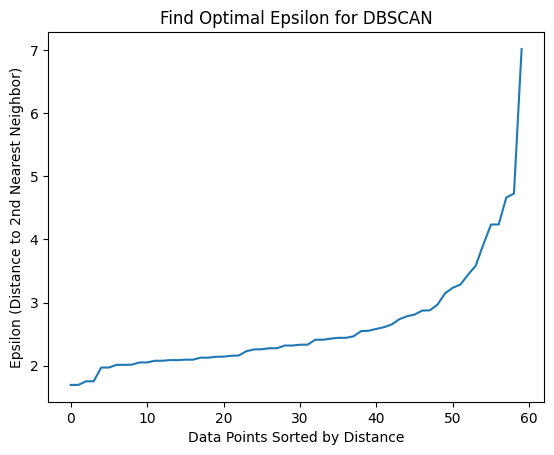

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# Compute nearest neighbor distances
nearest_neighbors = NearestNeighbors(n_neighbors=2)
neighbors = nearest_neighbors.fit(X_scaled)
distances, indices = neighbors.kneighbors(X_scaled)

# Sort and plot distances
sorted_distances = np.sort(distances[:, 1])  # Use the 2nd nearest neighbor distance
plt.plot(sorted_distances)
plt.xlabel("Data Points Sorted by Distance")
plt.ylabel("Epsilon (Distance to 2nd Nearest Neighbor)")
plt.title("Find Optimal Epsilon for DBSCAN")
plt.show()


# **Few Shot classification**

In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import requests
import zipfile
import soundfile as sf
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import plotly.express as px
import plotly.graph_objects as go
from tensorflow.keras import layers, models, optimizers
import random


In [2]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [3]:
def download_esc50():
    """Download and extract ESC-50 dataset"""
    os.makedirs('data', exist_ok=True)

    if not os.path.exists("data/ESC-50-master"):
        url = "https://github.com/karoldvl/ESC-50/archive/master.zip"
        response = requests.get(url, stream=True)

        print("Downloading ESC-50 dataset...")
        with open("data/ESC-50.zip", "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)

        print("Extracting dataset...")
        with zipfile.ZipFile("data/ESC-50.zip", 'r') as zip_ref:
            zip_ref.extractall("data")

        print("Dataset downloaded and extracted successfully!")
    else:
        print("Dataset already exists!")

In [30]:
def load_and_preprocess_audio(file_path, target_sr=16000, target_duration=5):
    """Load and preprocess audio file"""
    audio, sr = librosa.load(file_path, sr=target_sr)

    target_length = target_sr * target_duration
    if len(audio) > target_length:
        audio = audio[:target_length]
    else:
        audio = np.pad(audio, (0, max(0, target_length - len(audio))))

    return audio

In [31]:
def create_spectrogram(audio):
    """Create mel spectrogram from audio"""
    mel_spec = librosa.feature.melspectrogram(
        y=audio,
        sr=16000,
        n_mels=128,
        n_fft=2048,
        hop_length=512
    )

    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec_db = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())

    return mel_spec_db

In [32]:
class FewShotDataGenerator:
    def __init__(self, data_path, meta_file, n_way=5, n_support=5, n_query=5):
        self.data_path = data_path
        self.n_way = n_way
        self.n_support = n_support
        self.n_query = n_query
        self.meta_df = pd.read_csv(meta_file)
        self.classes = sorted(self.meta_df['category'].unique())

    def get_episode(self):
        episode_classes = random.sample(self.classes, self.n_way)

        support_specs = []
        support_labels = []
        query_specs = []
        query_labels = []

        for class_idx, class_name in enumerate(episode_classes):
            class_files = self.meta_df[self.meta_df['category'] == class_name]['filename'].tolist()
            selected_files = random.sample(class_files, self.n_support + self.n_query)

            # Support set
            for file_name in selected_files[:self.n_support]:
                file_path = os.path.join(self.data_path, file_name)
                audio = load_and_preprocess_audio(file_path)
                spec = create_spectrogram(audio)
                support_specs.append(spec)
                support_labels.append(class_idx)

            # Query set
            for file_name in selected_files[self.n_support:]:
                file_path = os.path.join(self.data_path, file_name)
                audio = load_and_preprocess_audio(file_path)
                spec = create_spectrogram(audio)
                query_specs.append(spec)
                query_labels.append(class_idx)

        return (np.array(support_specs), np.array(support_labels),
                np.array(query_specs), np.array(query_labels))

In [33]:
def create_encoder():
    """Create CNN encoder network"""
    input_shape = (128, 157, 1)

    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),

        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),

        layers.Conv2D(256, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),

        layers.Conv2D(512, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
    ])

    return model

In [34]:
class PrototypicalNetwork(models.Model):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.n_way = 5
        self.n_support = 5

    def compute_prototypes(self, support_images, support_labels):
        z_support = self.encoder(support_images)
        z_support = tf.reshape(z_support, [self.n_way, self.n_support, -1])
        return tf.reduce_mean(z_support, axis=1)

    def compute_distances(self, prototypes, query_images):
        z_query = self.encoder(query_images)
        z_query = tf.expand_dims(z_query, axis=1)
        prototypes = tf.expand_dims(prototypes, axis=0)
        return -tf.reduce_sum(tf.square(z_query - prototypes), axis=-1)

    def call(self, support_images, support_labels, query_images):
        prototypes = self.compute_prototypes(support_images, support_labels)
        return self.compute_distances(prototypes, query_images)

In [49]:
import tensorflow as tf
import numpy as np
import plotly.graph_objects as go
from tqdm import tqdm
from tensorflow.keras import optimizers

# Check GPU availability
print("Checking GPU availability...")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Configure GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"Found {len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found. Running on CPU")

# Enable device placement logging
tf.debugging.set_log_device_placement(True)

# Use mixed precision for better GPU performance
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Use strategy for multi-GPU training
strategy = tf.distribute.MirroredStrategy()
print(f'Number of devices: {strategy.num_replicas_in_sync}')

# Define model and optimizer inside strategy scope
with strategy.scope():
    encoder = create_encoder()  # Ensure this function is defined
    model = PrototypicalNetwork(encoder)  # Ensure this class is defined
    optimizer = optimizers.Adam(learning_rate=0.001)

    # Training function inside strategy scope
    @tf.function
    def train_step(support_images, support_labels, query_images, query_labels):
     with tf.GradientTape() as tape:
        distances = model(support_images, support_labels, query_images)
        log_probabilities = tf.nn.log_softmax(distances, axis=-1)
        loss = -tf.reduce_mean(tf.gather(log_probabilities, query_labels, axis=-1))

     gradients = tape.gradient(loss, model.trainable_variables)
     optimizer.apply_gradients(zip(gradients, model.trainable_variables))

     predictions = tf.argmax(distances, axis=-1, output_type=tf.int32)  # 🔥 Ensure int32
     query_labels = tf.cast(query_labels, tf.int32)  # 🔥 Ensure int32

     accuracy = tf.reduce_mean(tf.cast(predictions == query_labels, tf.float32))
     return loss, accuracy


# Training loop (must run inside strategy)
def train_prototypical_network(n_episodes=1000):
    """Train the prototypical network using multi-GPU if available"""

    data_generator = FewShotDataGenerator(  # Ensure this class is defined
        data_path="data/ESC-50-master/audio",
        meta_file="data/ESC-50-master/meta/esc50.csv"
    )

    train_losses = []
    train_accuracies = []

    # Plot setup
    fig = go.Figure()
    fig.add_trace(go.Scatter(name='Loss', y=train_losses))
    fig.add_trace(go.Scatter(name='Accuracy', y=train_accuracies))

    for episode in tqdm(range(n_episodes), desc="Training"):
        support_images, support_labels, query_images, query_labels = data_generator.get_episode()

        # Convert data to tensors & move to GPU
        support_images = tf.cast(np.expand_dims(support_images, -1), tf.float32)
        query_images = tf.cast(np.expand_dims(query_images, -1), tf.float32)
        support_labels = tf.cast(support_labels, tf.int32)
        query_labels = tf.cast(query_labels, tf.int32)

        # Use strategy.run() to distribute training step
        loss, accuracy = strategy.run(
            train_step, args=(support_images, support_labels, query_images, query_labels)
        )

        # Convert distributed results to scalar values
        loss = strategy.reduce(tf.distribute.ReduceOp.MEAN, loss, axis=None)
        accuracy = strategy.reduce(tf.distribute.ReduceOp.MEAN, accuracy, axis=None)

        train_losses.append(float(loss))
        train_accuracies.append(float(accuracy))

        # Update progress plot every 50 episodes
        if (episode + 1) % 50 == 0:
            fig.data[0].y = train_losses
            fig.data[1].y = train_accuracies
            fig.update_layout(
                title='Training Progress',
                xaxis_title='Episode',
                yaxis_title='Value',
                yaxis_range=[0, 1]
            )
            fig.show()

            print(f"Episode {episode + 1}/{n_episodes}")
            print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

    return model, train_losses, train_accuracies




Checking GPU availability...
Num GPUs Available:  1
Physical devices cannot be modified after being initialized
Number of devices: 1


In [37]:
download_esc50()

Dataset already exists!


In [39]:
meta_df = pd.read_csv('data/ESC-50-master/meta/esc50.csv')

In [50]:
model, losses, accuracies = train_prototypical_network(n_episodes=250)

Training:  20%|█▉        | 49/250 [00:49<02:50,  1.18it/s]

Training:  20%|██        | 50/250 [00:50<02:43,  1.22it/s]

Episode 50/250
Loss: 1.6094, Accuracy: 0.3600


Training:  40%|███▉      | 99/250 [01:35<02:19,  1.08it/s]

Training:  40%|████      | 100/250 [01:35<02:11,  1.14it/s]

Episode 100/250
Loss: 1.6094, Accuracy: 0.2000


Training:  60%|█████▉    | 149/250 [02:17<01:17,  1.31it/s]

Training:  60%|██████    | 150/250 [02:18<01:16,  1.31it/s]

Episode 150/250
Loss: 1.6094, Accuracy: 0.3600


Training:  80%|███████▉  | 199/250 [03:00<00:39,  1.29it/s]

Training:  80%|████████  | 200/250 [03:00<00:38,  1.28it/s]

Episode 200/250
Loss: 1.6094, Accuracy: 0.4400


Training: 100%|█████████▉| 249/250 [03:45<00:00,  1.29it/s]

Training: 100%|██████████| 250/250 [03:46<00:00,  1.10it/s]

Episode 250/250
Loss: 1.6094, Accuracy: 0.3200
